### 1. 数据读入

In [1]:
import pandas as pd
df = pd.read_csv('50_Startups.csv')
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


### 2. 数据归一化

In [2]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean())/column.std())

df = normalize_feature(df[['R&D Spend', 'Marketing Spend', 'Profit']])
df.head()

,R&D Spend,Marketing Spend,Profit
0,1.996146,2.132295,1.990990
1,1.936203,1.904267,1.979335
2,1.736731,1.610180,1.960934
3,1.539157,1.407916,1.758771
4,1.489812,1.268648,1.344094


In [3]:
# 数据分析（3D）
# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.set_xlabel('R&D Spend')
# ax.set_ylabel('Marketing Spend')
# ax.set_zlabel('Profit')
# ax.scatter3D(df['R&D Spend'], df['Marketing Spend'], df['Profit'], c=df['Profit'], cmap='Reds')

### 3. 数据处理

In [4]:
import numpy as np

# 为了方便矩阵相乘，添加一列全为1的x0
ones = pd.DataFrame({'ones': np.ones(len(df))})  # ones是n行1列的数据框，表示x0恒为1
df = pd.concat([ones, df], axis=1)  # 根据列合并数据

X_data = np.array(df[df.columns[0:3]])
Y_data = np.array(df[df.columns[-1]]).reshape(len(df), 1)

print(X_data.shape, type(X_data))
print(Y_data.shape, type(Y_data))
df.head()

(50, 3) <class 'numpy.ndarray'>
(50, 1) <class 'numpy.ndarray'>


,ones,R&D Spend,Marketing Spend,Profit
0,1.0,1.996146,2.132295,1.990990
1,1.0,1.936203,1.904267,1.979335
2,1.0,1.736731,1.610180,1.960934
3,1.0,1.539157,1.407916,1.758771
4,1.0,1.489812,1.268648,1.344094


### 4. 创建线性回归模型（数据流图）

In [5]:
import tensorflow as tf

tf.reset_default_graph() #  https://www.cnblogs.com/demo-deng/p/10365889.html

alpha = 0.01  # 学习率
epoch = 500 # 训练全量数据集的轮数

# 创建线性回归模型（数据流图）
with tf.name_scope('input'):
    # 输入X, 形状[50,3]
    X = tf.placeholder(tf.float32, X_data.shape, name='X')
    # 输入Y,形状[50,1]
    Y = tf.placeholder(tf.float32, Y_data.shape, name='Y')

# 权重变量W，形状[3,1]
with tf.name_scope('hypothesis'):
    # 存疑：tf.get_variable_scope().reuse_variables()  # https://cloud.tencent.com/developer/article/1335672
    W = tf.get_variable("weights", (X_data.shape[1], 1), initializer=tf.constant_initializer())

    # 假设函数 h(x) = w0*x0+w1*x1+w2*x2,其中x0恒为1
    # 推理值 Y_pred 形状[47,10]
    Y_pred = tf.matmul(X, W)

with tf.name_scope('loss'):
    # 损失函数采用最小二乘法，Y_pred - y 是形如[47,1]的向量
    # tf.matmul(a, b, transpose_a=True) 表示： 矩阵a的转置乘矩阵b,及[1,47] x [47,1]
    # 损失函数操作 loss
    loss_op = 1 / (2 * len(X_data)) * tf.matmul((Y_pred - Y), (Y_pred - Y), transpose_a=True)

with tf.name_scope('train'):
    # 随机梯度下降优化器 opt
    opt = tf.train.GradientDescentOptimizer(learning_rate=alpha)
    # 单步训练操作 train_op
    train_op = opt.minimize(loss_op)

### 5. 创建会话（运行环境）

In [6]:
# 创建会话（运行环境）
with tf.Session() as sess:
    # 初始化全局变量
    sess.run(tf.global_variables_initializer())
    
    # 创建 FileWriter 实例
    writer = tf.summary.FileWriter("./summary/linear-regression-1/", sess.graph)
    
    loss_data = []
    # 开始训练模型
    # 因为训练集较小，所以不采用批梯度下降优化算法，每次都采用全量数据训练
    for e in range(1, epoch+1):
        sess.run(train_op, feed_dict={X: X_data, Y: Y_data})
        if e % 10 == 0:
            _,loss, w = sess.run([train_op, loss_op, W], feed_dict={X: X_data, Y: Y_data})
            # 记录每一轮损失值变化情况
            loss_data.append(float(loss))
            log_str = "Epoch %d \t Loss=%.4g \t Model: y = %.4gx1 + %.4gx2 + %.4g"
            print(log_str % (e, loss, w[1], w[2], w[0]))
    
# 关闭FileWriter的输出流
writer.close()
# tensorboard --logdir ./ --host localhost

Epoch 10 	 Loss=0.3661 	 Model: y = 0.09726x1 + 0.07332x2 + 7.451e-11
Epoch 20 	 Loss=0.2701 	 Model: y = 0.1796x1 + 0.1324x2 + 7.078e-10
Epoch 30 	 Loss=0.2035 	 Model: y = 0.2495x1 + 0.1798x2 + 2.98e-10
Epoch 40 	 Loss=0.1571 	 Model: y = 0.3091x1 + 0.2174x2 + -1.155e-09
Epoch 50 	 Loss=0.1247 	 Model: y = 0.36x1 + 0.2471x2 + 8.196e-10
Epoch 60 	 Loss=0.1019 	 Model: y = 0.4037x1 + 0.2702x2 + 7.078e-10
Epoch 70 	 Loss=0.08567 	 Model: y = 0.4414x1 + 0.2879x2 + 1.49e-10
Epoch 80 	 Loss=0.07409 	 Model: y = 0.4741x1 + 0.3011x2 + 8.009e-10
Epoch 90 	 Loss=0.06568 	 Model: y = 0.5026x1 + 0.3107x2 + 1.639e-09
Epoch 100 	 Loss=0.05949 	 Model: y = 0.5275x1 + 0.3173x2 + 2.403e-09
Epoch 110 	 Loss=0.05484 	 Model: y = 0.5495x1 + 0.3215x2 + 3.427e-09
Epoch 120 	 Loss=0.05128 	 Model: y = 0.569x1 + 0.3237x2 + 3.856e-09
Epoch 130 	 Loss=0.04849 	 Model: y = 0.5863x1 + 0.3244x2 + 3.334e-09
Epoch 140 	 Loss=0.04624 	 Model: y = 0.6019x1 + 0.3237x2 + 3.669e-09
Epoch 150 	 Loss=0.04439 	 Model: y =

### 6. 可视化损失值

In [7]:
print(len(loss_data), loss_data)

50 [0.3661213517189026, 0.27011415362358093, 0.20349600911140442, 0.15711453557014465, 0.12467682361602783, 0.10185541212558746, 0.08567407727241516, 0.07408539205789566, 0.0656803622841835, 0.059489019215106964, 0.05484314635396004, 0.051282115280628204, 0.04848800227046013, 0.046241018921136856, 0.04438899829983711, 0.04282620921730995, 0.041478972882032394, 0.040295686572790146, 0.039239950478076935, 0.03828589990735054, 0.03741493821144104, 0.03661353141069412, 0.03587164729833603, 0.03518170863389969, 0.03453788533806801, 0.03393556922674179, 0.033371005207300186, 0.03284109756350517, 0.03234320878982544, 0.03187505528330803, 0.031434621661901474, 0.031020084396004677, 0.03062981739640236, 0.03026231937110424, 0.02991621196269989, 0.029590202495455742, 0.02928311936557293, 0.028993820771574974, 0.0287212785333395, 0.02846449799835682, 0.02822258323431015, 0.027994660660624504, 0.027779920026659966, 0.027577588334679604, 0.02738695777952671, 0.027207350358366966, 0.0270381234586238

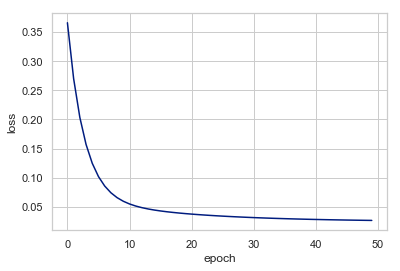

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='notebook', style='whitegrid', palette='dark')

ax = sns.lineplot(x='epoch', y='loss', data=pd.DataFrame({'loss': loss_data, 'epoch': np.arange(epoch/10)}))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()